In [1]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# Constant current injections will be made to these neurons.
stimulus = {
  "PLML": 1.4,
  "PLMR": 1.4,
}

# Neurons to plot membrane potentials for.
neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AIY",
  "ALM",
  "ASE",
  "ASH",
  "ASK",
  "AWA",
  "AWB",
  "AWC",
  "ASK",
  "IL1",
  "IL2",
  "PLM",
  "RIV",
  "RMD"
  ])

# How many timesteps to run simulation for.
simul_time = 2000

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

# Run the model

In [2]:
from model.neural_model import NeuralModel
from util.plot_util import *

model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

for (neuron, current) in stimulus.items():
  model.set_current_injection(neuron, current)
model.init_kunert_2017()
(v_mat, s_mat, v_normalized_mat) = model.run(simul_time)

# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
truncated_potentials = v_normalized_mat[300:,:]

# Plot potentials of selected neurons

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


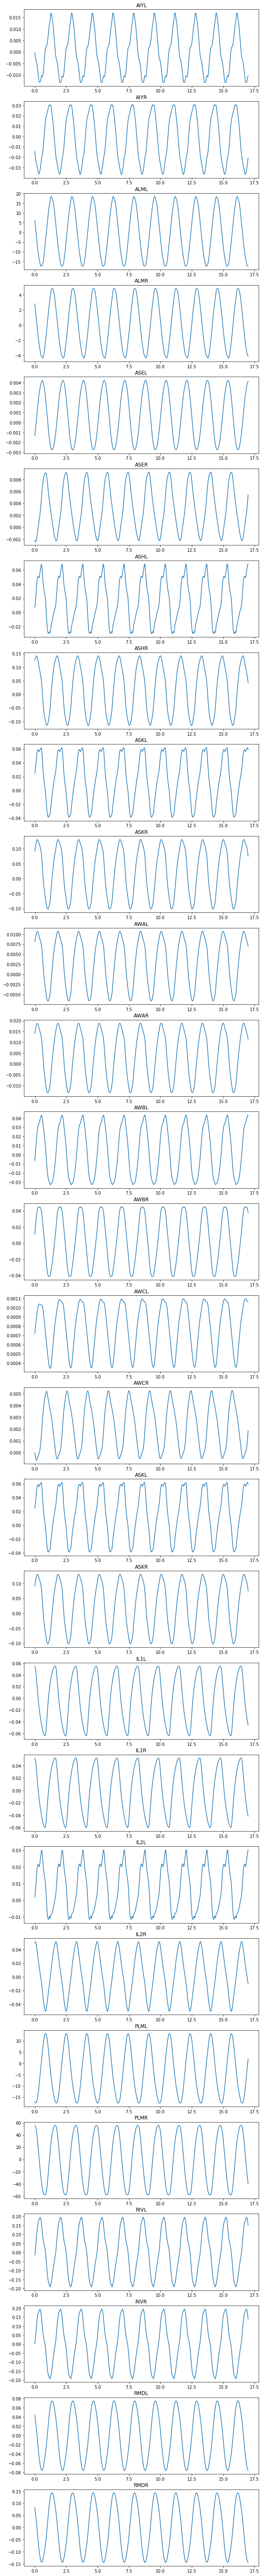

In [3]:
fig = plot_potentials(neurons_to_observe, truncated_potentials, neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

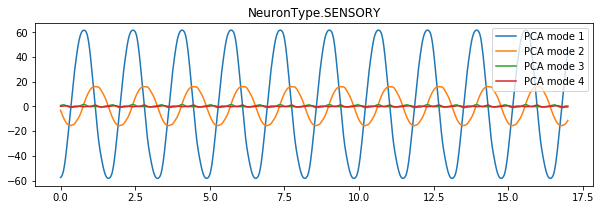

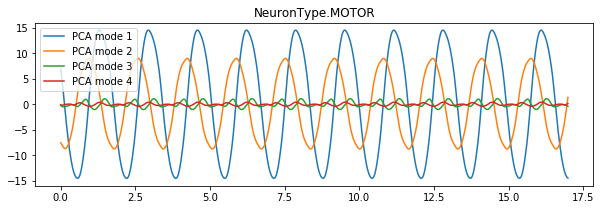

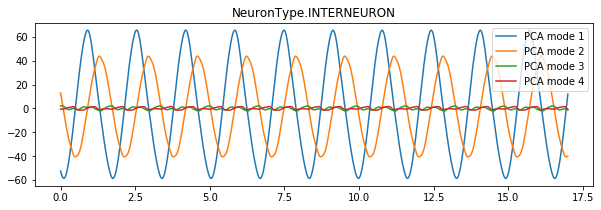

In [4]:
from sklearn.decomposition import PCA

for neuron_type in [NeuronType.SENSORY, NeuronType.MOTOR, NeuronType.INTERNEURON]:
  relevant_ids = neuron_metadata_collection.get_neuron_ids_by_neuron_type(neuron_type)
  relevant_potentials = truncated_potentials[:, relevant_ids]
  num_pca_comps = 4
  pca = PCA(n_components = num_pca_comps)
  projected_X = pca.fit_transform(relevant_potentials)

  dt = 0.01
  times = np.arange(0, projected_X.shape[0] * model.dt , model.dt)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
  for pca_comp in range(num_pca_comps):
    ax.set_title(neuron_type)
    ax.plot(times, projected_X[:,pca_comp], label = "PCA mode {0:d}".format(pca_comp+1))
    ax.legend()
_ = _